# Atmospheric, oceanic and land data handling

In this notebook we discuss the subtleties of how NetCDF-SCM handles different data 'realms' and why these choices are made. The realms of intereset to date are atmosphere, ocean and land and the discussion between the realms follows the [CMIP6 realm controlled vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_realm.json).

TODO: make this notebook follow something like the following outline

1. Oceanic data handling (as it's the simplest)
    - choices
    - why
1. Land data handling
    - choices
    - why
1. Atmospheric data handling
    - choices
    - why

In [1]:
from os.path import join

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube
from netcdf_scm.utils import broadcast_onto_lat_lon_grid

<IPython.core.display.Javascript object>

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel(logging.WARNING)
root_logger.addHandler(logging.StreamHandler())

In [4]:
DATA_PATH_TEST = join("..", "tests", "test-data")

In [5]:
tas_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "CNRM-CERFACS",
    "CNRM-ESM2-1",
    "1pctCO2",
    "r1i1p1f2",
    "Amon",
    "tas",
    "gr",
    "v20181018",
    "tas_Amon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_199701-199912.nc",
)

gpp_file = tas_file.replace(
    "Amon", "Lmon"
).replace(
    "tas", "gpp"
)

csoilfast_file = gpp_file.replace("gpp", "cSoilFast")

sftlf_file = gpp_file.replace("gpp", "cSoilFast")

In [6]:
tas = CMIP6OutputCube()
tas.load_data_from_path(tas_file)

gpp = CMIP6OutputCube()
gpp.load_data_from_path(gpp_file)

csoilfast = CMIP6OutputCube()
csoilfast.load_data_from_path(csoilfast_file)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [7]:
tas.cube

<iris 'Cube' of air_temperature / (K) (time: 36; latitude: 128; longitude: 256)>

In [8]:
gpp.cube

<iris 'Cube' of gross_primary_productivity_of_biomass_expressed_as_carbon / (kg m-2 s-1) (time: 36; latitude: 128; longitude: 256)>

In [9]:
csoilfast.cube

<iris 'Cube' of fast_soil_pool_carbon_content / (kg m-2) (time: 36; latitude: 128; longitude: 256)>

In [10]:
sftlf = tas.get_metadata_cube("sftlf")
sftlf.cube

<iris 'Cube' of land_area_fraction / (%) (latitude: 128; longitude: 256)>

In [11]:
areacella = tas.get_metadata_cube("areacella")
areacella.cube

<iris 'Cube' of cell_area / (m2) (latitude: 128; longitude: 256)>

In [12]:
tas_land = tas.get_scm_cubes(masks=["World|Land"])["World|Land"]

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


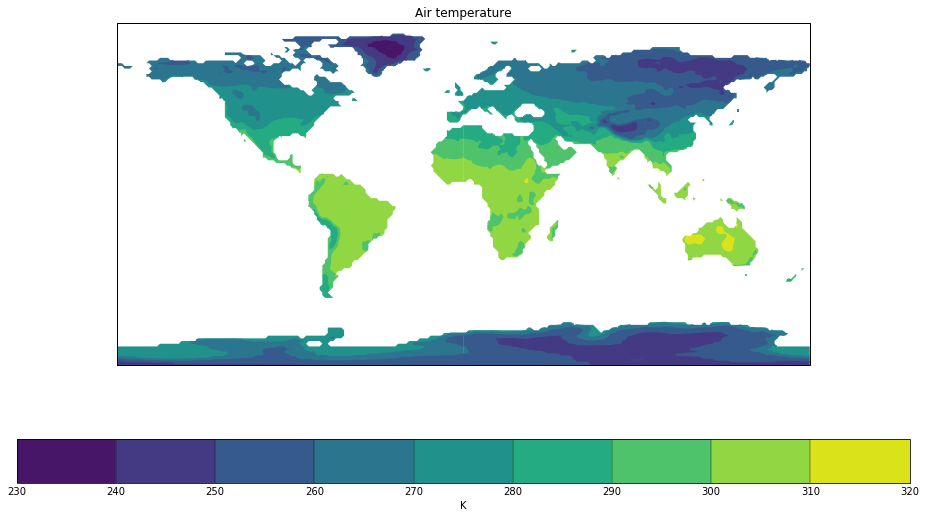

In [13]:
plt.figure(figsize=(16, 9))
qplt.contourf(tas_land.cube[0, :, :]);

In [14]:
tas_land_unweighted_mean = tas_land.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN
)

area_weights = broadcast_onto_lat_lon_grid(tas_land, areacella.cube.data)
tas_land_area_weighted_mean= tas_land.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=area_weights
)

try:
    tas_land.cube.coord("latitude").guess_bounds()
    tas_land.cube.coord("longitude").guess_bounds()
except ValueError:
    pass

tas_land_default_area_weighted_mean = tas_land.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=iris.analysis.cartography.area_weights(tas_land.cube)
)

area_sftlf_weights = broadcast_onto_lat_lon_grid(tas_land, areacella.cube.data * sftlf.cube.data)
tas_land_area_sftlf_weighted_mean = tas_land.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=area_sftlf_weights
)

Collapsing spatial coordinate 'latitude' without weighting
Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
Using DEFAULT_SPHERICAL_EARTH_RADIUS.


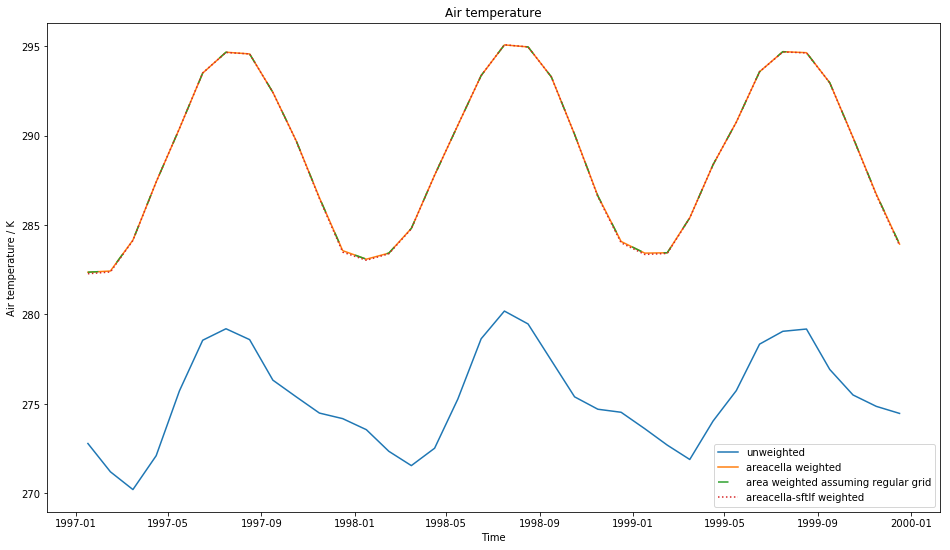

In [15]:
plt.figure(figsize=(16, 9))
qplt.plot(tas_land_unweighted_mean, label="unweighted")
qplt.plot(tas_land_area_weighted_mean, label="areacella weighted")
qplt.plot(
    tas_land_default_area_weighted_mean, 
    label="area weighted assuming regular grid", 
    linestyle="--",
    dashes=(7, 15)
)
qplt.plot(
    tas_land_area_sftlf_weighted_mean, 
    label="areacella-sftlf weighted", 
    linestyle=":",
)

plt.legend();

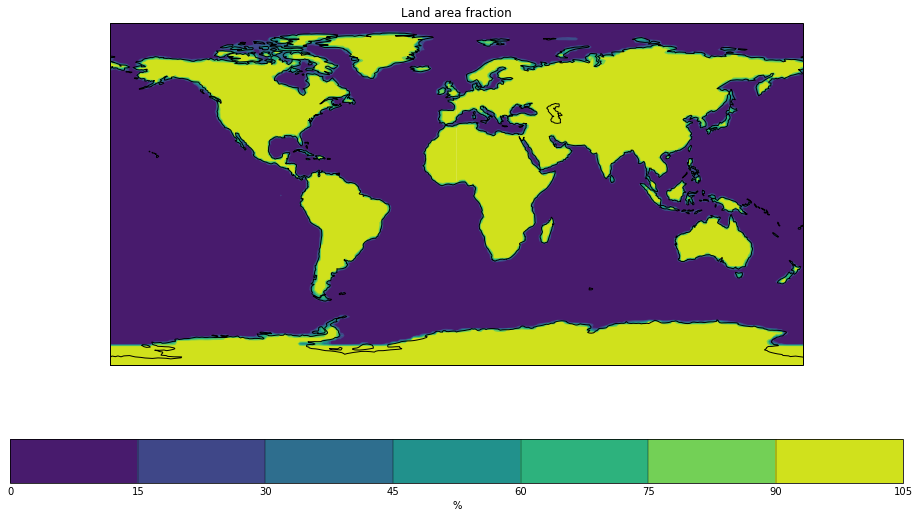

In [16]:
plt.figure(figsize=(16, 9))
qplt.contourf(sftlf.cube)
plt.gca().coastlines();

In [17]:
no_weights = areacella.cube.copy()
no_weights.data = np.ones_like(no_weights.data)

default_weights = areacella.cube.copy()
default_weights.data = iris.analysis.cartography.area_weights(tas_land.cube)[0, :, :]
default_weights.data = default_weights.data / default_weights.data.sum()

areacella_weights = areacella.cube.copy()
areacella_weights.data = areacella_weights.data / areacella_weights.data.sum()

areacella_sftlf_weights = areacella.cube.copy()
areacella_sftlf_weights.data = area_sftlf_weights[0, :, :]
areacella_sftlf_weights.data = areacella_sftlf_weights.data / areacella_sftlf_weights.data.sum()

No contour levels were found within the data range.


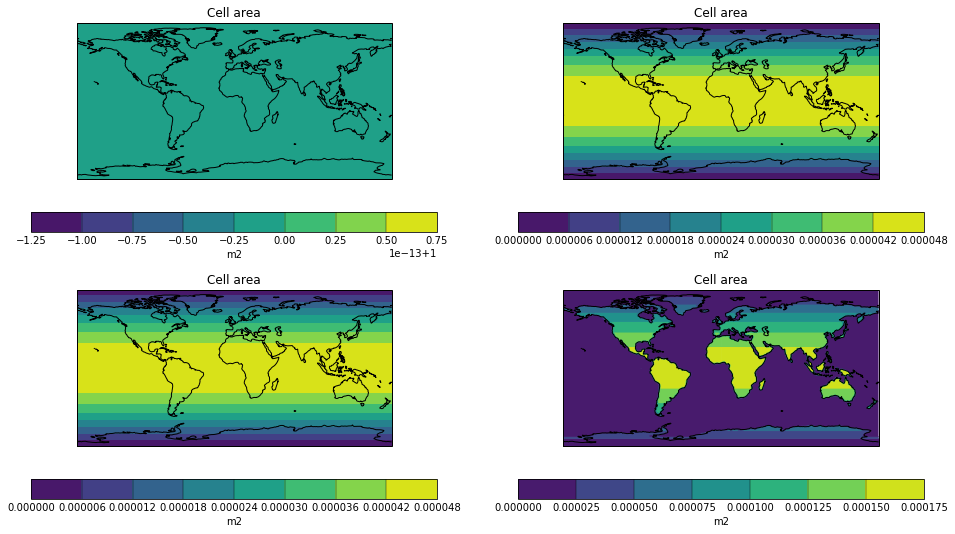

In [18]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
qplt.contourf(no_weights)
plt.gca().coastlines()
plt.subplot(222)
qplt.contourf(areacella_weights)
plt.gca().coastlines()
plt.subplot(223)
qplt.contourf(default_weights)
plt.gca().coastlines()
plt.subplot(224)
qplt.contourf(areacella_sftlf_weights)
plt.gca().coastlines();

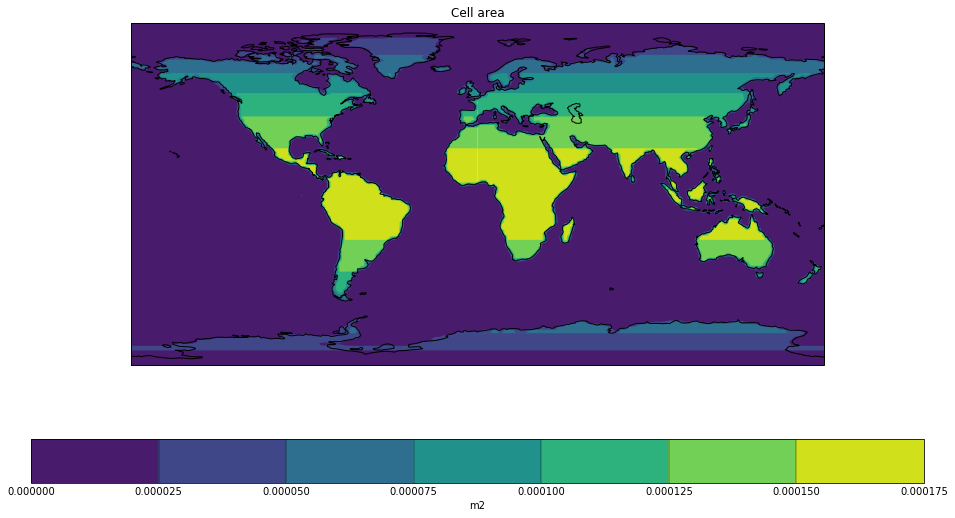

In [19]:
plt.figure(figsize=(16, 9))
qplt.contourf(areacella_sftlf_weights)
plt.gca().coastlines();

In [20]:
(tas_land.cube[0, :, :].data.mask == (sftlf.cube.data < 50).data).all()

True

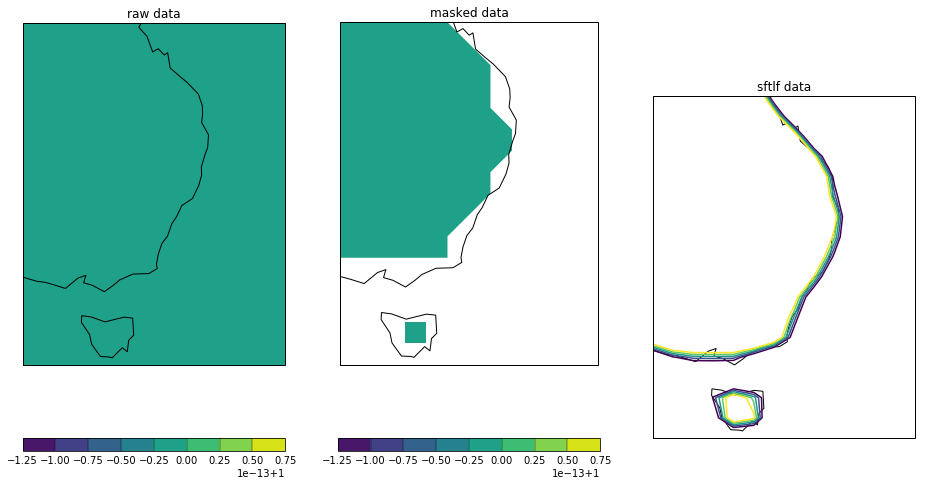

In [21]:
lat_con = iris.Constraint(latitude=lambda cell: -45 < cell < -20)
lon_con = iris.Constraint(longitude=lambda cell: 140 < cell < 160)
plt.figure(figsize=(16, 9))

plt.subplot(131)
qplt.contourf((tas.cube[0, :, :] / tas.cube[0, :, :]).extract(
    lat_con & lon_con
))#, levels=np.arange(290, 314, 0.1))
plt.gca().coastlines()
plt.title("raw data")

plt.subplot(132)
qplt.contourf((tas_land.cube[0, :, :] / tas_land.cube[0, :, :]).extract(
    lat_con & lon_con
))#, levels=np.arange(290, 314, 0.1))
plt.gca().coastlines()
plt.title("masked data")

plt.subplot(133)
qplt.contour(sftlf.cube.extract(
    lat_con & lon_con
), levels=[0, 40, 45, 50, 55, 60, 100])
plt.gca().coastlines()
plt.title("sftlf data");

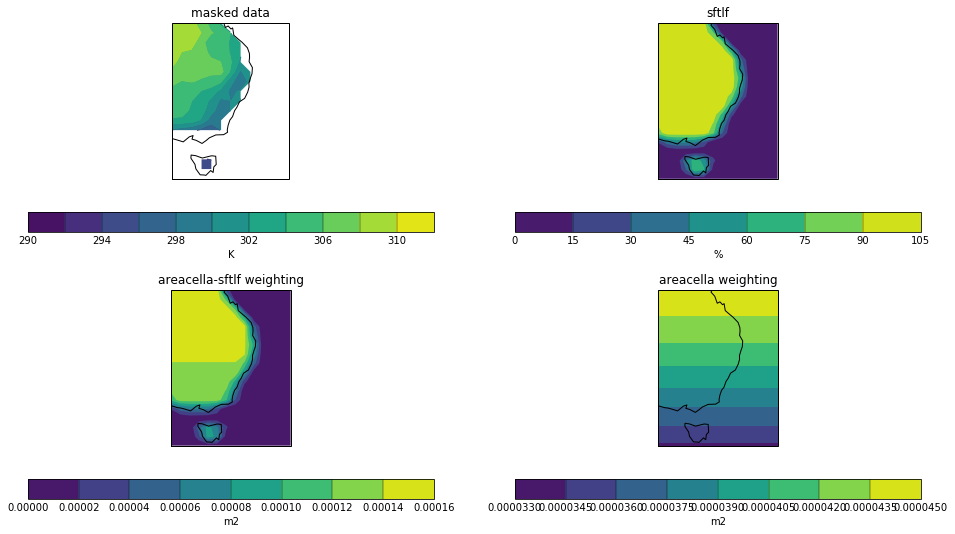

In [22]:
plt.figure(figsize=(16, 9))

plt.subplot(221)
qplt.contourf(tas_land.cube[0, :, :].extract(
    lat_con & lon_con
), levels=np.arange(290, 314, 2))
plt.gca().coastlines()
plt.title("masked data")

plt.subplot(222)
qplt.contourf(sftlf.cube.extract(
    lat_con & lon_con
))
plt.gca().coastlines()
plt.title("sftlf")

plt.subplot(223)
qplt.contourf(areacella_sftlf_weights.extract(
    lat_con & lon_con
))
plt.gca().coastlines()
plt.title("areacella-sftlf weighting")

plt.subplot(224)
qplt.contourf(areacella_weights.extract(
    lat_con & lon_con
))
plt.gca().coastlines()
plt.title("areacella weighting");

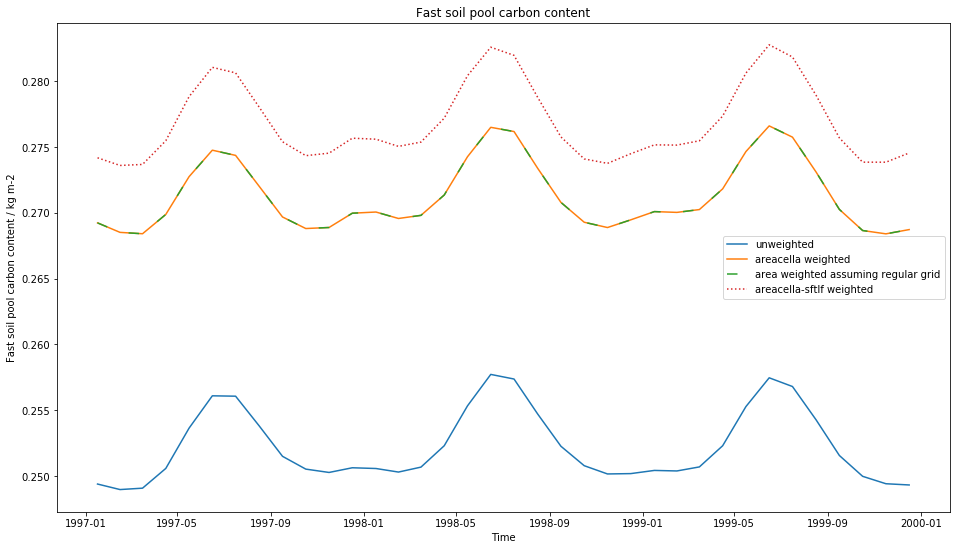

In [23]:
csoilfast_unweighted_mean = csoilfast.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN
)

area_weights = broadcast_onto_lat_lon_grid(csoilfast, areacella.cube.data)
csoilfast_area_weighted_mean= csoilfast.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=area_weights
)

try:
    csoilfast.cube.coord("latitude").guess_bounds()
    csoilfast.cube.coord("longitude").guess_bounds()
except ValueError:
    pass

csoilfast_default_area_weighted_mean = csoilfast.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=iris.analysis.cartography.area_weights(csoilfast.cube)
)

area_sftlf_weights = broadcast_onto_lat_lon_grid(csoilfast, areacella.cube.data * sftlf.cube.data)
csoilfast_area_sftlf_weighted_mean = csoilfast.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=area_sftlf_weights
)
plt.figure(figsize=(16, 9))
qplt.plot(csoilfast_unweighted_mean, label="unweighted")
qplt.plot(csoilfast_area_weighted_mean, label="areacella weighted")
qplt.plot(
    csoilfast_default_area_weighted_mean, 
    label="area weighted assuming regular grid", 
    linestyle="--",
    dashes=(7, 15)
)
qplt.plot(
    csoilfast_area_sftlf_weighted_mean, 
    label="areacella-sftlf weighted", 
    linestyle=":",
)

plt.legend();

Text(0.5,1,'raw data')

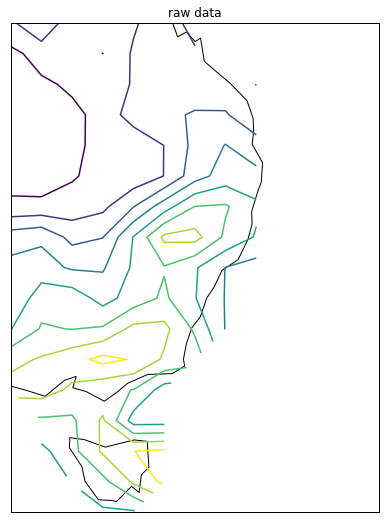

In [24]:
lat_con = iris.Constraint(latitude=lambda cell: -45 < cell < -20)
lon_con = iris.Constraint(longitude=lambda cell: 140 < cell < 160)
plt.figure(figsize=(16, 9))

# plt.subplot(111)
qplt.contour(csoilfast.cube[0, :, :].extract(
    lat_con & lon_con
))#, levels=np.arange(290, 314, 2))
plt.gca().coastlines()
plt.title("raw data")

In [25]:
csoilfast.cube

<iris 'Cube' of fast_soil_pool_carbon_content / (kg m-2) (time: 36; latitude: 128; longitude: 256)>

In [26]:
csoilfast.cube[0, :, :].data

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)